In [ ]:
# 기존 DeepDTA의 모델을 따 Protein Protein interaction 예측에 활용해보기 위함

## Data Loader / Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras

from sklearn.model_selection import train_test_split

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/바이오 AI 융합 해커톤/train.csv')
test = pd.read_csv('/content/drive/MyDrive/바이오 AI 융합 해커톤/test.csv')

## EDA

In [ ]:
train.head(5)

,ID,frag_1,frag_2,h_bond_distance
0,TRAIN_0000000,TLGR,VALV,15.0
1,TRAIN_0000001,AILTCPF,GRIVPRF,20.0
2,TRAIN_0000002,LRLSCA,MQLYVT,17.0
3,TRAIN_0000003,TASVVCLLNN,SLTLTSSLSY,25.0
4,TRAIN_0000004,VKLYL,ILVSD,19.0


In [ ]:
print(f'Train data number : {len(train)}')

Train data number : 1699067


In [ ]:
train.h_bond_distance.describe() # 17 - 19 - 21

count    1.699067e+06
mean     1.929865e+01
std      3.972532e+00
min      4.000000e+00
25%      1.700000e+01
50%      1.900000e+01
75%      2.100000e+01
max      3.700000e+01
Name: h_bond_distance, dtype: float64

In [ ]:
frag_1_Length = [len(i) for i in train['frag_1']]

In [ ]:
train['protein_Length'] = frag_1_Length

In [ ]:
train.protein_Length.describe()

count    1.699067e+06
mean     6.500604e+00
std      2.149286e+00
min      3.000000e+00
25%      5.000000e+00
50%      6.000000e+00
75%      8.000000e+00
max      5.700000e+01
Name: protein_Length, dtype: float64

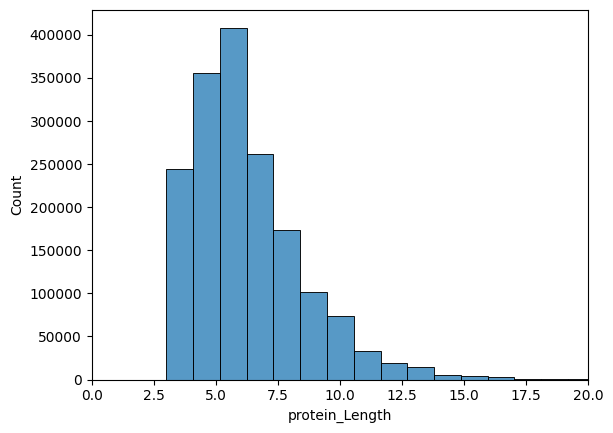

In [ ]:
sns.histplot(data=train, x='protein_Length',bins=50)
plt.xlim(0,20)
plt.show() # 패딩 길이 잡기..

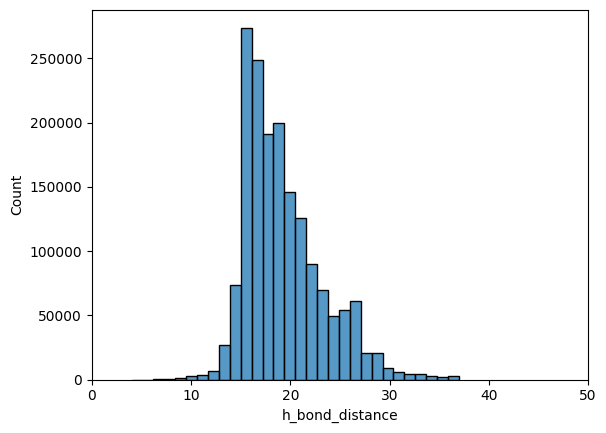

In [ ]:
sns.histplot(data=train, x='h_bond_distance',bins=30)
plt.xlim(0,50)
plt.show()

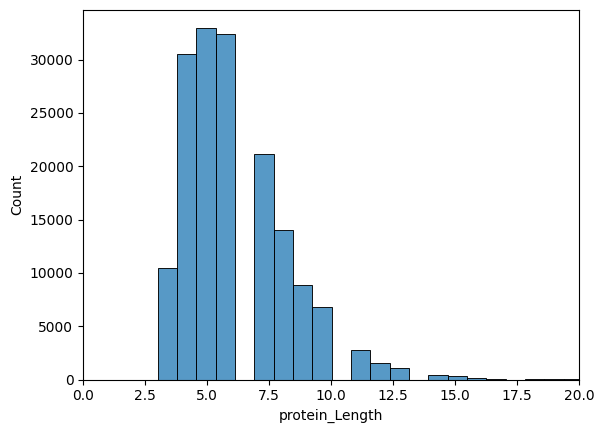

In [ ]:
# 뭔가 test의 protein length도 확인을 해야할 것 같은 기분
frag_1_Length = [len(i) for i in test['frag_1']]
test['protein_Length'] = frag_1_Length

sns.histplot(data=test, x='protein_Length',bins=50)
plt.xlim(0,20)
plt.show()

In [ ]:
test.protein_Length.describe()

count    163537.000000
mean          6.117735
std           2.225750
min           3.000000
25%           4.000000
50%           6.000000
75%           7.000000
max          42.000000
Name: protein_Length, dtype: float64

In [ ]:
train.protein_Length.describe()

count    1.699067e+06
mean     6.500604e+00
std      2.149286e+00
min      3.000000e+00
25%      5.000000e+00
50%      6.000000e+00
75%      8.000000e+00
max      5.700000e+01
Name: protein_Length, dtype: float64

## Preprocessing

In [ ]:
# 토큰화(패딩길이 정하기) / 정수 인코딩 / 모델 넣기.

# Amino Vocab부터 만들기 20개인데 그냥 직접 만듬.
amino_vocab = {'<PAD>':0, 'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}

In [ ]:
class protein_tokenize():
  def __init__(self, target_vocab):
    self.target_vocab = target_vocab
    self.target_Length = 15 # 길이 조정 필요

  def padding(self, encoded, drug=True):
    return encoded + (self.target_Length - len(encoded)) * [self.target_vocab['<PAD>']]

  def protein_encode(self, target):
    encoded = [self.target_vocab[i] for i in target[:self.target_Length]]
    return np.array(self.padding(encoded, False))

In [ ]:
# 근데 Train에서 잘 못 나누면 검증 set에서 data leakage 일어나는 듯
a = train.frag_1.copy()
b = train.frag_2.copy()
label = train.h_bond_distance.copy()

In [ ]:
a_train, a_valid, label_train, label_valid = train_test_split(a,label,test_size=0.1, random_state= 42)
b_train, b_valid, label_train, label_valid = train_test_split(b,label,test_size=0.1, random_state= 42)

In [ ]:
print(a_train[0],b_train[0], '\n \n',train.head(1))

TLGR VALV 
 
               ID frag_1 frag_2  h_bond_distance
0  TRAIN_0000000   TLGR   VALV             15.0


In [ ]:
tokenize = protein_tokenize(amino_vocab)

train_token_1 = np.vstack([tokenize.protein_encode(i) for i in a_train])
train_token_2 = np.vstack([tokenize.protein_encode(i) for i in b_train])

valid_token_1 = np.vstack([tokenize.protein_encode(i) for i in a_valid])
valid_token_2 = np.vstack([tokenize.protein_encode(i) for i in b_valid])


test_token_1 = np.vstack([tokenize.protein_encode(i) for i in test.frag_1])
test_token_2 = np.vstack([tokenize.protein_encode(i) for i in test.frag_2])

## Model / Test

In [ ]:
class PPI_model(tf.keras.Model):
    def __init__(self, target_vocab, embedding_dim):
        super(PPI_model, self).__init__()
        self.protein_embedding_1 = tf.keras.layers.Embedding(input_dim=len(target_vocab), output_dim=embedding_dim)
        self.protein_embedding_2 = tf.keras.layers.Embedding(input_dim=len(target_vocab), output_dim=embedding_dim)

        self.protein_1_ConvLayers = tf.keras.Sequential([
            tf.keras.layers.Conv1D(32, 2, activation='relu', padding='valid', strides=1),
            tf.keras.layers.Conv1D(32, 3, activation='relu', padding='valid', strides=1)])

        self.protein_1_pooling = tf.keras.layers.GlobalMaxPooling1D()

        self.protein_2_ConvLayers = tf.keras.Sequential([
            tf.keras.layers.Conv1D(32, 2, activation='relu', padding='valid', strides=1),
            tf.keras.layers.Conv1D(32, 3, activation='relu', padding='valid', strides=1)])

        self.protein_2_pooling = tf.keras.layers.GlobalMaxPooling1D()

        # self.attention = 예정

        self.merge = tf.keras.layers.Concatenate(axis=-1)  # Change axis to 1

        self.FC_layers = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(1, activation=None)
        ])

    def call(self, inputs):
        protein_data1, protein_data2 = inputs
        x1 = self.protein_embedding_1(protein_data1)
        x2 = self.protein_embedding_2(protein_data2)

        x1 = self.protein_1_ConvLayers(x1)
        x2 = self.protein_2_ConvLayers(x2)

        x1 = self.protein_1_pooling(x1)
        x2 = self.protein_2_pooling(x2)

        # Apply attention (예정)

        encoded_interaction = self.merge([x1, x2])
        prediction = self.FC_layers(encoded_interaction)
        return prediction

# Create an instance of your model
model = PPI_model(amino_vocab, 32)

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Compile the model
model.compile(optimizer='adam', loss= rmse, metrics=['mean_absolute_error'])

model_checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/바이오 AI 융합 해커톤/best_ppi_model.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

callbacks_list = [model_checkpoint]

# Fit the model to your data
model.fit((train_token_1, train_token_2), label_train, batch_size=128, callbacks=callbacks_list, validation_data=[(valid_token_1,valid_token_2),label_valid], epochs=30) # 높은 확률로 train/valid에서 data leakage인듯

Epoch 1/30
11947/11947 [==============================] - ETA: 0s - loss: 2.4221 - mean_absolute_error: 1.6797
Epoch 1: val_loss improved from inf to 2.39942, saving model to /content/drive/MyDrive/바이오 AI 융합 해커톤/best_ppi_model.h5
11947/11947 [==============================] - 94s 7ms/step - loss: 2.4221 - mean_absolute_error: 1.6797 - val_loss: 2.3994 - val_mean_absolute_error: 1.6132
Epoch 2/30
11946/11947 [============================>.] - ETA: 0s - loss: 2.1478 - mean_absolute_error: 1.4434
Epoch 2: val_loss improved from 2.39942 to 2.07166, saving model to /content/drive/MyDrive/바이오 AI 융합 해커톤/best_ppi_model.h5
11947/11947 [==============================] - 89s 7ms/step - loss: 2.1478 - mean_absolute_error: 1.4434 - val_loss: 2.0717 - val_mean_absolute_error: 1.3636
Epoch 3/30
11943/11947 [============================>.] - ETA: 0s - loss: 2.0652 - mean_absolute_error: 1.3800
Epoch 3: val_loss did not improve from 2.07166
11947/11947 [===========================

In [ ]:
'''
Epoch 10/10
10620/10620 [==============================] - 78s 7ms/step - loss: 3.2161 - mean_absolute_error: 1.1556 - val_loss: 3.2395(MSE) -> 1.79 - val_mean_absolute_error: 1.1486

Epoch 5: val_loss improved from 1.98328 to 1.94633, saving model to /content/drive/MyDrive/바이오 AI 융합 해커톤/best_ppi_model.h5
11947/11947 [==============================] - 83s 7ms/step - loss: 1.9748 - mean_absolute_error: 1.3105 - val_loss: 1.9463 - val_mean_absolute_error: 1.2791
'''

'\nEpoch 10/10\n10620/10620 [==============================] - 78s 7ms/step - loss: 3.2161 - mean_absolute_error: 1.1556 - val_loss: 3.2395(MSE) -> 1.79 - val_mean_absolute_error: 1.1486\n\nEpoch 5: val_loss improved from 1.98328 to 1.94633, saving model to /content/drive/MyDrive/바이오 AI 융합 해커톤/best_ppi_model.h5\n11947/11947 [==============================] - 83s 7ms/step - loss: 1.9748 - mean_absolute_error: 1.3105 - val_loss: 1.9463 - val_mean_absolute_error: 1.2791\n'

In [ ]:
# test_pred = model.predict((test_token_1, test_token_2))

In [ ]:
# Create an instance of your model
best_ppi_model = PPI_model(amino_vocab, 32)


best_ppi_model.build([(None, 12),(None, 12)])

# Load the weights
best_ppi_model.load_weights('/content/drive/MyDrive/바이오 AI 융합 해커톤/best_ppi_model.h5')

# Compile the model
best_ppi_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Now, you can use the model for predictions
test_pred = best_ppi_model.predict((test_token_1, test_token_2))


5111/5111 [==============================] - 13s 2ms/step


In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/바이오 AI 융합 해커톤/sample_submission.csv')
submit['h_bond_distance'] = test_pred

import time
time_ = time.strftime("%m%d_%M", time.localtime())

submit.to_csv(f'/content/drive/MyDrive/바이오 AI 융합 해커톤/submition_ppi_{time_}.csv', index=False)

## 어텐션 추가 모델

In [ ]:
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.units = units
        self.W_q = tf.keras.layers.Dense(units)
        self.W_k = tf.keras.layers.Dense(units)
        self.W_v = tf.keras.layers.Dense(units)
        self.attention = tf.keras.layers.Attention(use_scale=True)

    def call(self, x):
        q = self.W_q(x)
        k = self.W_k(x)
        v = self.W_v(x)

        attention_output = self.attention([q, k, v])
        return attention_output

class PPI_model(tf.keras.Model):
    def __init__(self, target_vocab, embedding_dim):
        super(PPI_model, self).__init__()
        self.protein_embedding_1 = tf.keras.layers.Embedding(input_dim=len(target_vocab), output_dim=embedding_dim)
        self.protein_embedding_2 = tf.keras.layers.Embedding(input_dim=len(target_vocab), output_dim=embedding_dim)

        self.protein_1_ConvLayers = tf.keras.Sequential([
            tf.keras.layers.Conv1D(32, 2, activation='relu', padding='valid', strides=1),
            tf.keras.layers.Conv1D(32, 3, activation='relu', padding='valid', strides=1)])

        self.protein_1_pooling = tf.keras.layers.GlobalMaxPooling1D()

        self.protein_2_ConvLayers = tf.keras.Sequential([
            tf.keras.layers.Conv1D(32, 2, activation='relu', padding='valid', strides=1),
            tf.keras.layers.Conv1D(32, 3, activation='relu', padding='valid', strides=1)])

        self.protein_2_pooling = tf.keras.layers.GlobalMaxPooling1D()

        self.self_attention_1 = SelfAttention(units=64)
        self.self_attention_2 = SelfAttention(units=64)

        self.merge = tf.keras.layers.Concatenate(axis=-1)

        self.FC_layers = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(1, activation=None)
        ])

    def call(self, inputs):
        protein_data1, protein_data2 = inputs
        x1 = self.protein_embedding_1(protein_data1)
        x2 = self.protein_embedding_2(protein_data2)

        x1 = self.protein_1_ConvLayers(x1)
        x2 = self.protein_2_ConvLayers(x2)

        x1_att = self.self_attention_1(x1)
        x2_att = self.self_attention_2(x2)

        x1 = self.merge([x1_att, x1])
        x2 = self.merge([x2_att, x2])

        x1 = self.protein_1_pooling(x1)
        x2 = self.protein_2_pooling(x2)

        encoded_interaction = self.merge([x1, x2])
        prediction = self.FC_layers(encoded_interaction)
        return prediction

In [ ]:
'''
Epoch 27: val_loss improved from 1.73812 to 1.72151, saving model to /content/drive/MyDrive/바이오 AI 융합 해커톤/best_ppi_model.h5
11947/11947 [==============================] - 131s 11ms/step - loss: 1.7142 - mean_absolute_error: 1.1227 - val_loss: 1.7215 - val_mean_absolute_error: 1.1003
'''

In [ ]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

model = PPI_model(amino_vocab, 32)

# Compile the model
model.compile(optimizer='adam', loss= rmse, metrics=['mean_absolute_error'])

model_checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/바이오 AI 융합 해커톤/best_ppi_model.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

callbacks_list = [model_checkpoint]

# Fit the model to your data
model.fit((train_token_1, train_token_2), label_train, batch_size=128, callbacks=callbacks_list, validation_data=[(valid_token_1,valid_token_2),label_valid], epochs=30)

Epoch 1/30
11943/11947 [============================>.] - ETA: 0s - loss: 2.3980 - mean_absolute_error: 1.6455
Epoch 1: val_loss improved from inf to 2.23951, saving model to /content/drive/MyDrive/바이오 AI 융합 해커톤/best_ppi_model.h5
11947/11947 [==============================] - 141s 11ms/step - loss: 2.3979 - mean_absolute_error: 1.6454 - val_loss: 2.2395 - val_mean_absolute_error: 1.4786
Epoch 2/30
11945/11947 [============================>.] - ETA: 0s - loss: 2.1388 - mean_absolute_error: 1.4294
Epoch 2: val_loss improved from 2.23951 to 2.09975, saving model to /content/drive/MyDrive/바이오 AI 융합 해커톤/best_ppi_model.h5
11947/11947 [==============================] - 132s 11ms/step - loss: 2.1387 - mean_absolute_error: 1.4294 - val_loss: 2.0997 - val_mean_absolute_error: 1.3510
Epoch 3/30
11947/11947 [==============================] - ETA: 0s - loss: 2.0422 - mean_absolute_error: 1.3553
Epoch 3: val_loss improved from 2.09975 to 2.00354, saving model to /content/drive/

In [ ]:
# Create an instance of your model
best_ppi_model = PPI_model(amino_vocab, 32)

best_ppi_model.build([(None, 15),(None, 15)])

# Load the weights
best_ppi_model.load_weights('/content/drive/MyDrive/바이오 AI 융합 해커톤/best_ppi_model.h5')

# Compile the model
best_ppi_model.compile(optimizer='adam', loss=rmse , metrics=['mean_absolute_error'])

# Now, you can use the model for predictions
test_pred = best_ppi_model.predict((test_token_1, test_token_2))

submit = pd.read_csv('/content/drive/MyDrive/바이오 AI 융합 해커톤/sample_submission.csv')
submit['h_bond_distance'] = test_pred

import time
time_ = time.strftime("%m%d_%M", time.localtime())

submit.to_csv(f'/content/drive/MyDrive/바이오 AI 융합 해커톤/submition_ppi_{time_}.csv', index=False)

5111/5111 [==============================] - 19s 4ms/step


## other attention model

In [ ]:
class LocationBasedAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LocationBasedAttention, self).__init__()
        self.units = units
        self.W_q = tf.keras.layers.Dense(units)
        self.W_k = tf.keras.layers.Dense(units)
        self.W_v = tf.keras.layers.Dense(units)

    def build(self, input_shape):
        self.position_encoding = self.add_weight(name='position_encoding',
                                                 shape=(1, input_shape[1], self.units),
                                                 initializer='uniform',
                                                 trainable=True)

    def call(self, x):
        q = self.W_q(x)
        k = self.W_k(x)
        v = self.W_v(x)

        # 위치 인코딩 추가
        q += self.position_encoding
        k += self.position_encoding

        # Scaled Dot-Product Attention 계산
        attention_scores = tf.matmul(q, k, transpose_b=True)
        attention_scores = attention_scores / tf.math.sqrt(tf.cast(self.units, tf.float32))

        # 소프트맥스 함수를 사용하여 어텐션 가중치 계산
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)

        # 가중합 계산
        attention_output = tf.matmul(attention_weights, v)

        return attention_output

class PPI_model(tf.keras.Model):
    def __init__(self, target_vocab, embedding_dim):
        super(PPI_model, self).__init__()
        self.protein_embedding_1 = tf.keras.layers.Embedding(input_dim=len(target_vocab), output_dim=embedding_dim)
        self.protein_embedding_2 = tf.keras.layers.Embedding(input_dim=len(target_vocab), output_dim=embedding_dim)

        self.protein_1_ConvLayers = tf.keras.Sequential([
            tf.keras.layers.Conv1D(32, 2, activation='relu', padding='valid', strides=1),
            tf.keras.layers.Conv1D(32 , 3, activation='relu', padding='valid', strides=1)])

        self.protein_1_pooling = tf.keras.layers.GlobalMaxPooling1D()

        self.protein_2_ConvLayers = tf.keras.Sequential([
            tf.keras.layers.Conv1D(32, 2, activation='relu', padding='valid', strides=1),
            tf.keras.layers.Conv1D(32, 3, activation='relu', padding='valid', strides=1)])

        self.protein_2_pooling = tf.keras.layers.GlobalMaxPooling1D()

        self.attention_1 = LocationBasedAttention(units=64)
        self.attention_2 = LocationBasedAttention(units=64)

        self.merge = tf.keras.layers.Concatenate(axis=-1)

        self.FC_layers = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(1, activation=None)
        ])

    def call(self, inputs):
        protein_data1, protein_data2 = inputs
        x1 = self.protein_embedding_1(protein_data1)
        x2 = self.protein_embedding_2(protein_data2)

        x1 = self.protein_1_ConvLayers(x1)
        x2 = self.protein_2_ConvLayers(x2)

        x1_att = self.attention_1(x1)
        x2_att = self.attention_2(x2)

        x1 = self.merge([x1_att, x1])
        x2 = self.merge([x2_att, x2])

        x1 = self.protein_1_pooling(x1)
        x2 = self.protein_2_pooling(x2)

        encoded_interaction = self.merge([x1, x2])
        prediction = self.FC_layers(encoded_interaction)
        return prediction

In [ ]:
''' 이전 기록
Epoch 1: val_loss improved from inf to 2.23951, saving model to /content/drive/MyDrive/바이오 AI 융합 해커톤/best_ppi_model.h5
11947/11947 [==============================] - 141s 11ms/step - loss: 2.3979 - mean_absolute_error: 1.6454 - val_loss: 2.2395 - val_mean_absolute_error: 1.4786

Epoch 27: val_loss improved from 1.73812 to 1.72151, saving model to /content/drive/MyDrive/바이오 AI 융합 해커톤/best_ppi_model.h5
11947/11947 [==============================] - 131s 11ms/step - loss: 1.7142 - mean_absolute_error: 1.1227 - val_loss: 1.7215 - val_mean_absolute_error: 1.1003
'''

In [ ]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

model = PPI_model(amino_vocab, 32)

# Compile the model
model.compile(optimizer='adam', loss= rmse, metrics=['mean_absolute_error'])

model_checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/바이오 AI 융합 해커톤/best_ppi_model.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

callbacks_list = [model_checkpoint]

# Fit the model to your data
model.fit((train_token_1, train_token_2), label_train, batch_size=128, callbacks=callbacks_list, validation_data=[(valid_token_1,valid_token_2),label_valid], epochs=30)

Epoch 1/30
11947/11947 [==============================] - ETA: 0s - loss: 2.3892 - mean_absolute_error: 1.6405
Epoch 1: val_loss improved from inf to 2.40639, saving model to /content/drive/MyDrive/바이오 AI 융합 해커톤/best_ppi_model.h5
11947/11947 [==============================] - 135s 10ms/step - loss: 2.3892 - mean_absolute_error: 1.6405 - val_loss: 2.4064 - val_mean_absolute_error: 1.6104
Epoch 2/30
11944/11947 [============================>.] - ETA: 0s - loss: 2.0961 - mean_absolute_error: 1.3981
Epoch 2: val_loss improved from 2.40639 to 2.18372, saving model to /content/drive/MyDrive/바이오 AI 융합 해커톤/best_ppi_model.h5
11947/11947 [==============================] - 119s 10ms/step - loss: 2.0961 - mean_absolute_error: 1.3981 - val_loss: 2.1837 - val_mean_absolute_error: 1.4633
Epoch 3/30
11947/11947 [==============================] - ETA: 0s - loss: 1.9774 - mean_absolute_error: 1.3068
Epoch 3: val_loss did not improve from 2.18372
11947/11947 [=======================

KeyboardInterrupt: ignored

In [ ]:
# Create an instance of your model
best_ppi_model = PPI_model(amino_vocab, 32)

best_ppi_model.build([(None, 15),(None, 15)])

# Load the weights
best_ppi_model.load_weights('/content/drive/MyDrive/바이오 AI 융합 해커톤/best_ppi_model.h5')

# Compile the model
best_ppi_model.compile(optimizer='adam', loss=rmse , metrics=['mean_absolute_error'])

# Now, you can use the model for predictions
test_pred = best_ppi_model.predict((test_token_1, test_token_2))

submit = pd.read_csv('/content/drive/MyDrive/바이오 AI 융합 해커톤/sample_submission.csv')
submit['h_bond_distance'] = test_pred

import time
time_ = time.strftime("%m%d_%M", time.localtime())

submit.to_csv(f'/content/drive/MyDrive/바이오 AI 융합 해커톤/submition_ppi_{time_}.csv', index=False)

5111/5111 [==============================] - 17s 3ms/step
